# Conformal Prediction

The sparsity of observed instances gravely influences the degree of confidence a model prediction could have. Conformal prediction is an applicative technique that adds calibration process on top of any models to quantify uncertainties in data for both point estimators and prediction intervals. 

While there are different ways to carry out conformal prediction, NeuralProphet adopts the split conformal prediction, which requires a holdout or calibration set. To carry out split conformal prediction, dataset has to be split into three distinct sets for training, calibration and testing respectively. An initial prediction interval is created with the base quantile regression model trained by the training dataset. Target variables in the calibration set are being compared to the predicted value, which is denoted as the [quantified uncertainty](https://towardsdatascience.com/conformal-prediction-4775e78b47b6). The final conformal prediction interval is then formed by adding the quantified uncertainty to both tails of the predicted value.

You might select `Naive` or `Conformal Quantile Regression` for the conformal prediction in NeuralProphet. Here, we illustrate and further elaborate on the two models of conformal prediction using the hospital electric load dataset. The dataset has recorded the electricity consumption of a hospital in SF in 2015 by hour.

In [1]:
# much faster using the following code, but may not have the latest upgrades/bugfixes
# !pip install neuralprophet  

if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git  # may take a while

In [2]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

data_location = "http://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "energy/SF_hospital_load.csv")

### Data splitting

At least __two subsets (?)__ are needed in the conformal prediction feature in NeuralProphet. You may choose to opt in a validation subset in this model. If you want to add in a validation subset to train the base model, please make sure the period of the validation subset must be in between of the training and calibration subsets. In NeuralProphet, there is a data splitting function which divide a dataset input into two subsets. You can configure the function by indicating the time series frequencies and splitting ratio. List of frequency aliases can be found <a href= 'https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases'>here</a>.


In our hospital electric load dataset, we will first divide the original dataset into training and testing set with a train-test ratio of 0.9.

In [3]:
# Create NeuralProphet object 
m = NeuralProphet()

# Data spliting function split one timeseries dataframe into two
# Configure the hourly frequency by assigning 'H' to parameter freq
# Configure the splitting ratio with a value between 0 and 1 for valid_p
train_df, test_df = m.split_df(df, freq="H", valid_p=1.0 / 16)
train_df, cal_df = m.split_df(train_df, freq="H", valid_p=1.0 / 11)
# train_df, val_df = m.split_df(train_df, freq="H", valid_p=1.0 / 10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [4]:
train_df.shape, cal_df.shape, test_df.shape # val_df.shape

((7467, 2), (746, 2), (547, 2))

### Base model training
You can build any NeuralProphet model you deemed as fit as the base model. The calibration process in conformal prediction would be later added on the base model to quantify the uncertainty in our final estimation.

Back to our example, assuming we want to build an autoregression NeuralProphet model which can be providing us a prediction interval with 90% of confidence level. __Quantile are 5th and 95th__ You can refer to the [Autoregression](https://neuralprophet.com/notebooks/autoregression_yosemite_temps.html) and `Uncertainty Estimation with Quantile Regression` standalone tutorial sessions for the logic and applications of the features. We will be comparing the conformal prediction results between a simple and a complex 4-layer autoregression model in our illustration here.

In [5]:
#Parameter for autoregression
#Predict the value in the next hours based on the last three daysin an-hour steps
n_lags = 3 * 24 
print(n_lags)

72


In [6]:
#Parameter for quantile regression
confidence_lv = 0.9  
quantile_list = [round(((1 - confidence_lv) / 2), 2), confidence_lv + (1 - confidence_lv) / 2]
print(quantile_list)

[0.05, 0.95]


In [7]:
#Create a simple quantile regression model with no hypermeter tuning
m1 = NeuralProphet(
    quantiles=quantile_list
)

#Create a 4-layer autoregression model as the base
m2 = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantile_list
)

After finish configuring the model, we fit the model with the train set. If you have further split the training dataset into training and validation, you can either (i) concatenate the two datasets in one dataset for training or (ii) assign the training and validation datasets as two separated parameters. You can know more about the validation procedure in the [Phase Train, Validate and Test procedure](https://neuralprophet.com/notebooks/test_and_crossvalidate.html#3.-Advanced:-3-Phase-Train,-Validate-and-Test-procedure).

In [8]:
#Feed the training subset in the configured NeuralProphet models
#Configure the hourly frequency by assigning 'H' to parameter freq
set_random_seed(0)
metrics1 = m1.fit(train_df, freq="H")
metrics2 = m2.fit(train_df, freq="H")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (234) is too small than the required number for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Missing logger folder: /home/studio-lab-user/sagemaker-studiolab-notebooks/neural-prophet/neural_prophet/tutorials/feature-use/lightning_logs


Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111


Training: 0it [00:00, ?it/s]

We use the fitted base model to predict testing dataset. __Will get point and quantile regression prediction interval__

In [9]:
#Perform estimation for the testing data with the trained model
forecast1 = m1.predict(test_df)
forecast2 = m2.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


We can then plot the [predicted intervals] __add link__ to compare the performance of the models. With the same quantile parameter, the complex model has a much narrower prediction interval comparing to the simple model.

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


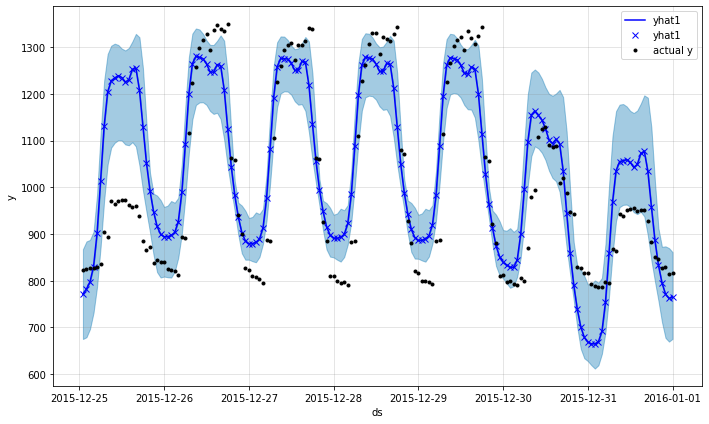

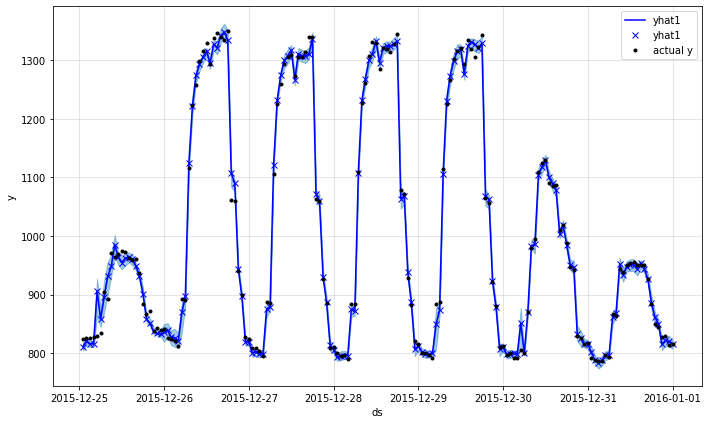

In [10]:
#Date range shown in the plots (optional)
cutoff = 7 * 24  # 0

#Plot the estimated value predicted with the base model
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast1[-cutoff:])
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast2[-cutoff:])

### Option 1: Naive Conformal Prediction

After training the base model, we then carry out the calibration process using the naive module. The steps are outlined as follow:
<br>i. predict the output value of the instances within the calibration set;
<br>ii. calculate absolute residual by comparing the actual and predicted value for each observation in the calibration set;
<br>iii. sort all absolute residual in ascending order; and
<br>iv. finds the quantified uncertainty(`q` or `qhat`) with the desired confidence level.
<br>v. use the quantified uncertainty(`q` or `qhat`) to make the final prediciton intervals

Going back to our example, we need to denote the parameter value for calibration set, significant level (alpha) for conformal prediction on top of the pre-trained models above.

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


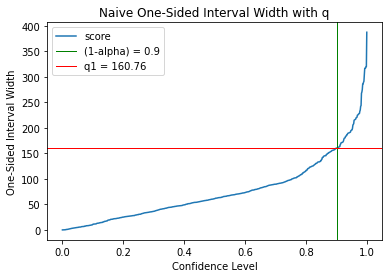

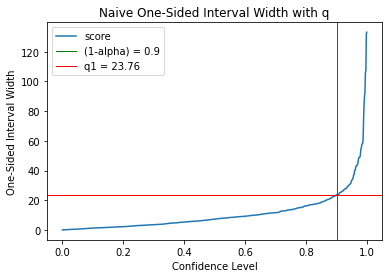

In [11]:
#Parameter for naive conformal prediction
method = "naive"
alpha = 1-confidence_lv

#Enable conformal predict on the pre-trained models
naive_forecast1 = m1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method
)
naive_forecast2 = m2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method
)

The plots above demonstrate how quantified uncertainty (`q`) change with different confidence level (`1-alpha`).  In the Naive conformal prediction, uncertainty is quantified using the *nonconformity score* which refers to the absolute differences between the actual and predicted value. We calculate the *nonconformity score* for each instance within the calibration dataset and arrange the score in an ascending order. The uncertainty (`q` or `qhat1`) is quantified by locating the noncomformity score at your desired confidence level. We will then add the uncertainty value (`q` or `qhat1`) to both sides of the prediction interval generated in the base model.

We plot the conformal prediction intervals again with the quantified uncertainty included (in red) below. m1 vs m2 red, red vs blue in general (how much dot capture and width), __Wider with m1 __

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


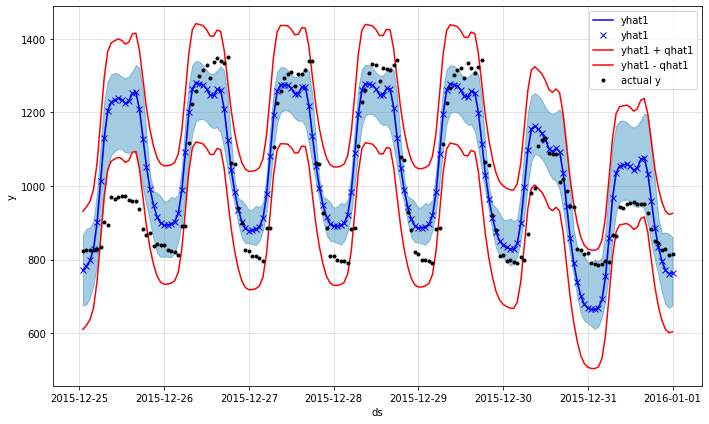

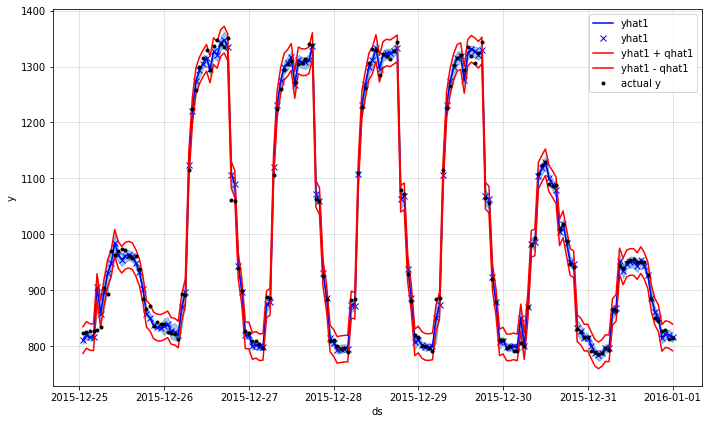

In [12]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(naive_forecast1[-cutoff:])
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(naive_forecast2[-cutoff:])

### Option 2: Conformal Quantile Regression

In [conformal quantile regression (CQR)](https://arxiv.org/abs/1905.03222), the method is run as follows:
<br>i. A sorted list of non-conformity scores is calculated as the differences between data points from the calibration dataset and their nearest prediction quantile, which provides a measure of how well the data fits the current quantile regression model.
<br>ii. The differences are calculated such they they are negative for data points within the quantile regression interval and positive if they are outside the interval.
<br>iii. The quantiles from the regression model are adjusted by an amount that satisfies the desired error rate, which is the portion of data points lying outside the interval, based on the calibration data's non-conformity scores.

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


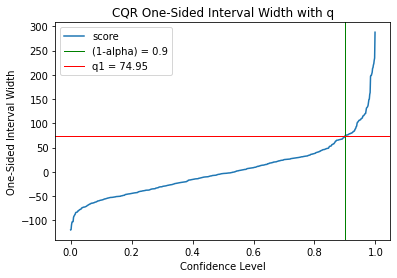

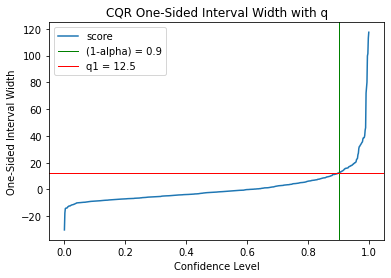

In [13]:
# Parameter for conformal quantile regression
method = "cqr"

# Enable conformal predict on the pre-trained models
cqr_forecast1 = m1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method
)
cqr_forecast2 = m2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method
)

The plots above show how the prediction interval bounds' adjustment, which is denoted $\hat{q}$, is calculated from the non-conformity scores of the calibration data and each quantile regression model m1 and m2. Given an error rate alpha, the sorted list of non-conformity scores yields a value of $\hat{q}$ such that the portion of scores in the list greater than $\hat{q}$ is equal to that error rate. What this means is that we update the prediction interval bounds based on the calibration data so that we are more reasonably confident that the training set data satisfies a similar error rate as alpha when compared to the new quantile regression model. There are two scenarios for what the CQR model means based on the value of $\hat{q}$.
- If the one-sided prediction interval width adjustment is **positive**, then CQR **extends** beyond the QR intervals, as it deems the QR interval to be too **confident**.
- Conversely, if the one-sided prediction interval width adjustment is **negative**, then CQR **contracts** the QR intervals, as it deems the QR interval to be too **conservative**.

Below are the $\hat{q}$ values for each model. As they are all positive, you will see the CQR interval extending beyond that of simple QR. Model m1 has a large gap between these two intervals since it has a larger $\hat{q}$ value, while for m2, the bounds are shifted much less.

In [14]:
cqr_qhat1 = cqr_forecast1.iloc[0]["qhat1"]
cqr_qhat2 = cqr_forecast2.iloc[0]["qhat1"]

cqr_qhat1, cqr_qhat2

(74.94919968203124, 12.504916046874996)

Plot QR forecasts and *CQR* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


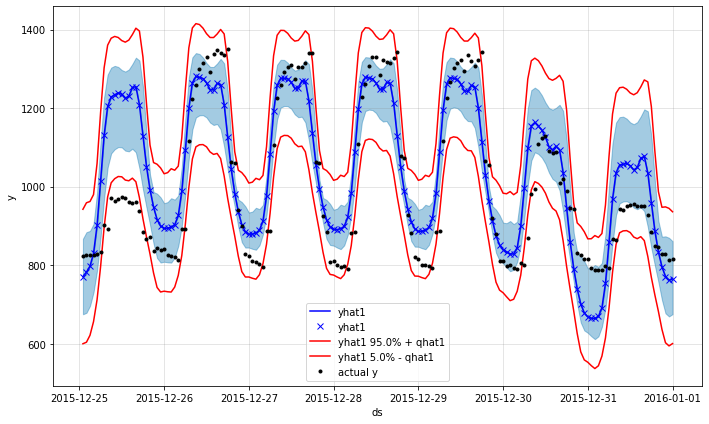

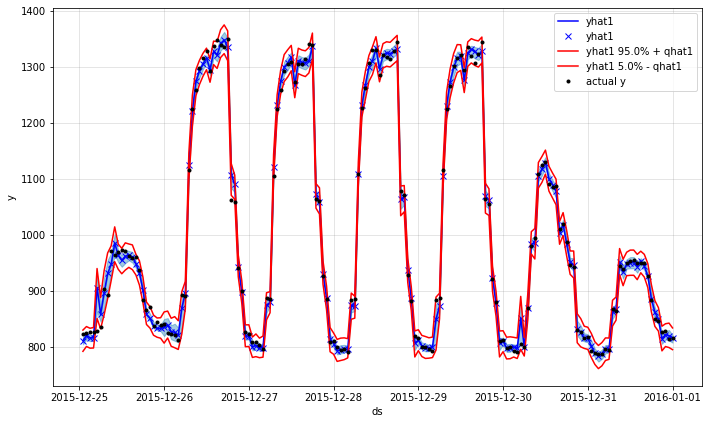

In [18]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(cqr_forecast1[-cutoff:])
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(cqr_forecast2[-cutoff:])


### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [19]:
conformal_methods = ["naive", "cqr"]
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ["interval_width", "miscoverage_rate"]]))
eval_df = eval_df.reset_index().rename(columns={"index": "model"})

Enter in the model names

In [20]:
eval_df["model"] = ["m1", "m2", "m3", "m4"]

Enter in the **interval_width** (*efficiency* metric)

In [21]:
# Naive interval width
naive_iw = [naive_qhat1 * 2, naive_qhat2 * 2, naive_qhat3 * 2, naive_qhat4 * 2]
eval_df["naive", "interval_width"] = naive_iw

NameError: name 'naive_qhat1' is not defined

In [ ]:
# Calculate CQR interval width function
def calc_cqr_iw(fcast_df, qr_lo, qr_hi, qhat):
    qr_lo_mean = fcast_df["yhat1"].mean() - fcast_df[f"yhat1 {qr_lo}%"].mean()
    qr_hi_mean = fcast_df[f"yhat1 {qr_hi}%"].mean() - fcast_df["yhat1"].mean()
    return qr_lo_mean + qr_hi_mean + qhat * 2

In [ ]:
# Quantile low/high values in string (%) format
quantile_lo_str = str(quantile_lo * 100)
quantile_hi_str = str(quantile_hi * 100)

In [ ]:
# CQR interval width
cqr_iw1 = calc_cqr_iw(cqr_forecast1, quantile_lo_str, quantile_hi_str, cqr_qhat1)
cqr_iw2 = calc_cqr_iw(cqr_forecast2, quantile_lo_str, quantile_hi_str, cqr_qhat2)
cqr_iw3 = calc_cqr_iw(cqr_forecast3, quantile_lo_str, quantile_hi_str, cqr_qhat3)
cqr_iw4 = calc_cqr_iw(cqr_forecast4, quantile_lo_str, quantile_hi_str, cqr_qhat4)

cqr_iw = [cqr_iw1, cqr_iw2, cqr_iw3, cqr_iw4]
eval_df["cqr", "interval_width"] = cqr_iw

Enter in the **miscoverage rate** (*validity* metric)

In [ ]:
# Calculate Naive miscoverage rate function
def calc_naive_mr(fcast_df):
    n_covered = fcast_df.apply(lambda row: bool(row["yhat1 - qhat1"] <= row["y"] <= row["yhat1 + qhat1"]), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [ ]:
# Naive miscoverage rate
naive_mr1 = calc_naive_mr(naive_forecast1)
naive_mr2 = calc_naive_mr(naive_forecast2)
naive_mr3 = calc_naive_mr(naive_forecast3)
naive_mr4 = calc_naive_mr(naive_forecast4)

naive_mr = [naive_mr1, naive_mr2, naive_mr3, naive_mr4]
eval_df["naive", "miscoverage_rate"] = naive_mr

In [ ]:
# Calculate CQR and CQR Advanced miscoverage rate function
def calc_cqr_mr(fcast_df, qr_lo, qr_hi):
    n_covered = fcast_df.apply(
        lambda row: bool(row[f"yhat1 {qr_lo}% - qhat1"] <= row["y"] <= row[f"yhat1 {qr_hi}% + qhat1"]), axis=1
    )
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [ ]:
# CQR miscoverage rate
cqr_mr1 = calc_cqr_mr(cqr_forecast1, quantile_lo_str, quantile_hi_str)
cqr_mr2 = calc_cqr_mr(cqr_forecast2, quantile_lo_str, quantile_hi_str)
cqr_mr3 = calc_cqr_mr(cqr_forecast3, quantile_lo_str, quantile_hi_str)
cqr_mr4 = calc_cqr_mr(cqr_forecast4, quantile_lo_str, quantile_hi_str)

cqr_mr = [cqr_mr1, cqr_mr2, cqr_mr3, cqr_mr4]
eval_df["cqr", "miscoverage_rate"] = cqr_mr

Show evaluation dataframe

In [ ]:
eval_df

**Summary**:

- The more complex the model m1->m4, the more accurate it is, hence the lower *interval width* and *miscoverage rate* metrics. The weaker models m1 and m2 have *miscoverage rate* above *alpha* of 0.1 while the stronger NN models m3 and m4 have *miscoverage rate* below *alpha*.
- For default model m1, CQR outputs narrower prediction *interval width* than Naive while maintaining the same *miscoverage rate*.
- However, for biased seasonality model m2,the Naive method has a narrower prediction *interval width* with a slightly better *miscoverage rate* than CQR.
- For complex m3 and m4 models, Naive and CQR methods have comparable *interval_width* and *miscoverage rate*. More testing needs to be done in order to determine which method is preferable to the other under which circumstances.